In [1]:

from splat.read_colmap import read_images_text, qvec2rotmat
from splat.scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

reconstruction = pycolmap.Reconstruction("/Users/derek/Desktop/colmap/gerrard-hall/sparse/0")

points3d = reconstruction.points3D
images = read_images_text("/Users/derek/Desktop/colmap/gerrard-hall/sparse/images.txt")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
for idx, point in enumerate(points3d.values()):
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 5:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color / 256)
    # if idx == 10000: break
        
scene = GaussianScene(torch.Tensor(np.array(all_points3d)), torch.Tensor(np.array(all_point_colors)))

In [2]:
# project all points to 2d
from splat.utils import get_intrinsic_matrix, get_extrinsic_matrix

image_num = 14

fx, fy, cx, cy = cameras[1].params[:4]
intrinsic_homogeneous = get_intrinsic_matrix(fx, fy, cx, cy)
image_qvec = images[image_num].qvec
image_tvec = images[image_num].tvec
# normalize the qvec
# image_qvec = image_qvec / np.linalg.norm(image_qvec)
image_rotation_matrix = qvec2rotmat(image_qvec)
image_translation = torch.Tensor(image_tvec)
extrinsic_matrix = get_extrinsic_matrix(image_rotation_matrix, image_translation)

points, z, covariances = scene.get_points_and_covariance(extrinsic_matrix=extrinsic_matrix, intrinsic_matrix=intrinsic_homogeneous)

In [4]:
covariances

tensor([[[ 7.8222e+02,  9.9824e+01],
         [ 9.9824e+01,  6.0258e+02]],

        [[ 4.8849e+02, -3.6892e+01],
         [-3.6892e+01,  3.8834e+02]],

        [[ 4.4514e+02,  5.8201e+01],
         [ 5.8201e+01,  3.4272e+02]],

        ...,

        [[ 1.2684e+03, -3.0435e+01],
         [-3.0435e+01,  1.2224e+03]],

        [[ 4.2450e+02, -3.5269e+01],
         [-3.5269e+01,  4.8587e+02]],

        [[ 1.0212e+02,  1.0920e+00],
         [ 1.0920e+00,  9.7914e+01]]], grad_fn=<SliceBackward0>)

In [3]:
import torch

with torch.no_grad():
    output_scene = scene.render_scene(
        projected_points=points,
        projected_covariances=covariances,
        z_component=z,
        height = 1000,
        width = 3000,
        tile_size=64
    )

torch.Size([3064, 1064, 3]) 46 15


100%|██████████| 46/46 [01:40<00:00,  2.19s/it]


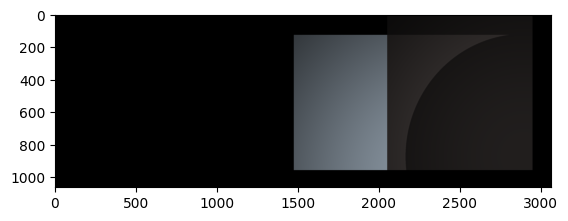

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

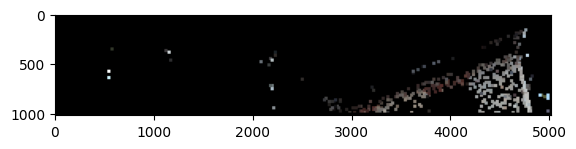

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))